### Importing Libraries

In [1]:
import dotenv
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import pandas as pd

# Load environment variables from .env file
dotenv.load_dotenv()
api_key = os.getenv("API_KEY")

In [2]:
from google import genai

client = genai.Client(api_key = api_key)

### VQA Dataset Preparation

In [3]:
SARVESH_START = 0
SARVESH_END = 6800
NATHAN_START = 6800
NATHAN_END = 13300
DIVYAM_START = 13300
DIVYAM_END = 20000

In [4]:
def chat_response(image_path, user_prompt, system_prompt):
    # Read the image as binary
    with open(image_path, "rb") as img_file:
        image_data = img_file.read()

    contents = [
        {
            "role": "user",
            "parts": [
                {"inline_data": {"mime_type": "image/jpeg", "data": image_data}},
                {"text": system_prompt+user_prompt}
            ]
        }
    ]

    model = "gemini-2.0-flash"
    response = client.models.generate_content(model=model, contents=contents)

    return response.text

In [5]:
def get_keywords(data):
    vqa_data = {}
    vqa_data["item_keywords"] = [kw.get("value", "") for kw in data.get("item_keywords", []) if kw.get("language_tag", "").startswith('en')]
    temp = vqa_data["item_keywords"].copy()
    keywords = ['color','product-type']
    for i in range(min(5, len(temp))):
        keywords.append(temp[i])
    return keywords

In [6]:
def preprocess_response(response):
    """
    Pre-process the response from chat_response.
    
    Expected format (as a JSON string):
    [
      ["Question 1", "Answer 1"],
      ["Question 2", "Answer 2"]
    ]
    
    This function removes extra text if necessary, extracts the JSON portion,
    and converts it into a Python list.
    """
    import json
    response = response.strip()
    start_index = response.find('[')
    end_index = response.rfind(']')
    if start_index != -1 and end_index != -1:
        json_str = response[start_index:end_index+1]
        try:
            qa_pairs = json.loads(json_str)
            return qa_pairs
        except json.JSONDecodeError as e:
            print("Error decoding JSON:", e)
    else:
        print("No JSON array found in the response.")

    return None

In [7]:
images_data = pd.read_csv("Dataset/metadata/image_data.csv")
# images_data.head()

In [8]:
if not os.path.exists("Dataset/metadata/image_data_with_vqa.csv"):
    images_data['vqa_response'] = None
    for index, row in images_data.iterrows():
        images_data.at[index, 'vqa_response'] = None
    images_data.to_csv("Dataset/metadata/image_data_with_vqa.csv", index=False)
else:
    print("The CSV file already exists. ")

The CSV file already exists. 


In [9]:
images_data = pd.read_csv("Dataset/metadata/image_data_with_vqa.csv")
# images_data.head()

In [ ]:
system_prompt = """
You are a Visual Question Answering (VQA) dataset generator.
Given an image and a list of metadata strings, generate diverse, high-quality question-answer pairs that cover visual recognition, attributes, relationships, metadata, and reasoning.
Make sure that the generated questions do not ask for any numerical answers.
Design the dataset so that people who are viewing the image are able to answer the questions.
Output each pair as a JSON response.
"""
count = 0
for i in range(SARVESH_START, SARVESH_END):
    if not pd.isna(images_data.iloc[i]['vqa_response']):
        print("Already generated for this image")
        continue
    count += 1
    image = images_data.iloc[i]['image_path']
    image_id = images_data.iloc[i]['image_id']
    print(image_id)
    
    listing = images_data.iloc[i]['listing']
    listing = json.loads(listing)
    keywords = get_keywords(listing)
    user_prompt = f"""
    Image ID: {image_id}
    Metadata: {keywords}
    Generate 2-3 question-answer pairs.
    """

    response = chat_response(image, user_prompt, system_prompt)
    response = preprocess_response(response)
    # print(response)
    print("Total images processed: ", count)
    images_data.at[i, 'vqa_response'] = json.dumps(response)
    images_data.to_csv("Dataset/metadata/image_data_with_vqa.csv", index=False)
    


Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
Already generated for this image
91IjyKZ76qL
Total images processed:  1
810fadO2BML
Total images processed:  2
61O+zPYa5AL
Total images processed:  3
71fT96mT39L
Total images processed:  4
71q5qvcwI7L
Total images processed:  5
61NxifiMbuL
Total images processed:  6
61XWVe-B-sL
Total images processed:  7
8

### TESTING

In [11]:
images_data = pd.read_csv("Dataset/metadata/image_data_with_vqa.csv")
images_data.head()

,image_id,image_path,listing,vqa_response
0,81iZlv3bjpL,Dataset/final_dataset/8ccb5859.jpg,"{""brand"": [{""language_tag"": ""nl_NL"", ""value"": ...","[{""question"": ""What kind of pattern does this ..."
1,619y9YG9cnL,Dataset/final_dataset/9f76d27b.jpg,"{""item_dimensions"": {""height"": {""normalized_va...","[{""question"": ""What type of product is in the ..."
2,81NP7qh2L6L,Dataset/final_dataset/665cc994.jpg,"{""item_dimensions"": {""height"": {""normalized_va...","[{""question"": ""What kind of material is this o..."
3,61Rp4qOih9L,Dataset/final_dataset/b4f9d0cc.jpg,"{""brand"": [{""language_tag"": ""en_GB"", ""value"": ...","[{""question"": ""What type of material is this f..."
4,714CmIfKIYL,Dataset/final_dataset/2b1c2516.jpg,"{""brand"": [{""language_tag"": ""en_AU"", ""value"": ...","[{""question"": ""What style of shoe is this?"", ""..."


In [12]:
#  print the vqa_response column for the first 20 rows
images_data['vqa_response'].head(22).to_list()

['[{"question": "What kind of pattern does this footwear have?", "answer": "snake skin"}, {"question": "What kind of shoes are shown in the image?", "answer": "Heels"}]',
 '[{"question": "What type of product is in the picture?", "answer": "drawer slides"}, {"question": "What color are the drawer slides?", "answer": "White"}, {"question": "What is the main color of the product shown?", "answer": "White"}]',
 '[{"question": "What kind of material is this object made of?", "answer": "PETG filament"}, {"question": "What type of product is shown in the image?", "answer": "3D printer filament"}]',
 '[{"question": "What type of material is this furniture made of?", "answer": "Fabric"}, {"question": "What type of couch is this?", "answer": "loveseat"}]',
 '[{"question": "What style of shoe is this?", "answer": "mocasines"}, {"question": "What color is this shoe?", "answer": "tan"}, {"question": "Is this footwear for women?", "answer": "Yes"}]',
 '[{"question": "What product is displayed in th

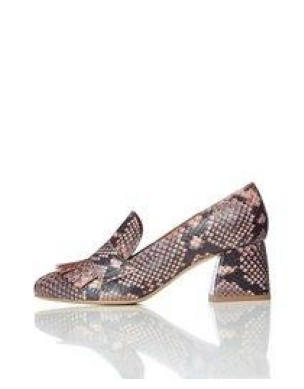

In [13]:
# load the image and display it
img = mpimg.imread("Dataset/final_dataset/8ccb5859.jpg")
plt.axis('off')
imgplot = plt.imshow(img)